In [1]:
import numpy as np
import scipy.io as sio
import os
import euGenFuncs as eu
import numpy as np
import pandas as pd
import pickle
import ieeg_funcs as ief
import dgFuncs as dg
from scipy.interpolate import UnivariateSpline
from scipy.stats import iqr
import matplotlib.pyplot as plt
%matplotlib inline
import imp 

In [6]:
in_file='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/KDOWNSAMP/kdownsampled_253.npz'
npz=np.load(in_file)
print(npz.keys())
print(npz['ftrs_dsamp'].shape)
print(npz['szr_class_dsamp'].shape)

['ftrs_dsamp', 'szr_class_dsamp', 'dsamp_wts']
(5598, 30)
(5598,)


In [11]:
np.max(npz['ftrs_dsamp'])

8483.2655066619263

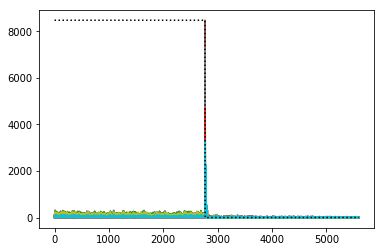

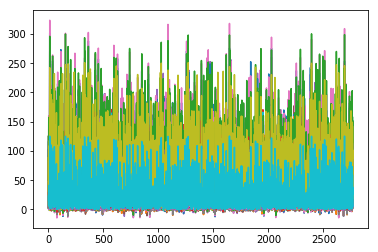

In [15]:
plt.figure(1)
plt.clf()
plt.plot(npz['ftrs_dsamp']);
plt.plot(npz['szr_class_dsamp']*np.max(npz['ftrs_dsamp']),'k:');

plt.figure(2)
plt.clf()
plt.plot(npz['ftrs_dsamp'][npz['szr_class_dsamp']==1,:]);

In [150]:
in_fnames

['kdownsampled_1077.npz',
 'kdownsampled_1096.npz',
 'kdownsampled_253.npz',
 'kdownsampled_565.npz',
 'kdownsampled_590.npz',
 'kdownsampled_620.npz',
 'kdownsampled_958.npz',
 'kdownsampled_970.npz']

In [173]:
## LOAD KMEANS DATA & TRY BRUTE FORCE THRESHOLDING TO DISCRIMINATE CLASSES
# list of subs
# subs=[253, 264]
#subs=[1077, 1096, 1125, 115, 253, 264, 273, 442, 565, 590, 620, 862, 922, 958, 970]


# Get file list & figure out max and min feature values
in_fnames=list() # List of kdownsampled*.npz files (1 per sub)
sub_list=list() # Corresponding list of subs
# find all subsamp files
in_dir='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/KDOWNSAMP/'
f_ct=0
for f in os.listdir(in_dir):
    if f.startswith('kdownsampled_'):
        in_fnames.append(f)
        tmp=f.split('_')[1]
        sub_list.append(int(tmp.split('.')[0]))
        mat=np.load(os.path.join(in_dir,f))
        if f_ct==0:
            min_ftrs=np.min(mat['ftrs_dsamp'],axis=0) # 30 dim vector
            max_ftrs=np.max(mat['ftrs_dsamp'],axis=0) # 30 dim vector
        else:
            min_ftrs=np.minimum(min_ftrs,np.min(mat['ftrs_dsamp'],axis=0)) # 30 dim vector
            max_ftrs=np.maximum(max_ftrs,np.max(mat['ftrs_dsamp'],axis=0)) # 30 dim vector
        f_ct+=1
        
n_band=6
band_labels=['Delta','Theta','Alpha','Beta','Gamma','HGamma']
n_edm=5
n_file=len(in_fnames)
print('%d files total' % n_file)

bin_edge_list=list()
n_bin_list=list()
n_targ_bin=500 #?? make bigger
ictal_p_list=list()
nonictal_p_list=list()
label_list=list()
bin_cntr_list=list()
acc_list=list()
for a in range(30):
    bin_cntr_list.append([])
    
# Create the histogram edges. Edges may differ across feature but are the same across subs
for edm_ct in range(n_edm):
    for b_ct in range(n_band):
        bin_edge_list.append(np.linspace(min_ftrs[b_ct+edm_ct*n_band],max_ftrs[b_ct+edm_ct*n_band],n_targ_bin))
        #bin_edge_list.append(np.logspace(min_ftrs[b_ct+edm_ct*n_band],max_ftrs[b_ct+edm_ct*n_band],n_targ_bin))
        n_bin_list.append(len(bin_edge_list[-1]))
        label_list.append(band_labels[b_ct]+'-EDM'+str(edm_ct))
        acc_list.append(np.zeros((n_file,n_bin_list[-1])))

        
# Loop over features and find best threshold for class discrimination
for f_ct, f in enumerate(in_fnames):
    mat=np.load(os.path.join(in_dir,f))
    n_wind[f_ct]=mat['ftrs_dsamp'].shape[0]
    
    # Loop over features
    for edm_ct in range(n_edm):
    #for edm_ct in range(1):
        raw_ftrs=mat['ftrs_dsamp'].T
        for b_ct in range(n_band):
            sens=np.zeros(len(bin_edge_list[b_ct+edm_ct*n_band]))
            spec=np.zeros(len(bin_edge_list[b_ct+edm_ct*n_band]))
            for thresh_ct, thresh in enumerate(bin_edge_list[b_ct+edm_ct*n_band]):
                    y_hat=(raw_ftrs[b_ct+edm_ct*n_band,:]>=thresh)
                    sens[thresh_ct]=np.mean(y_hat[mat['szr_class_dsamp']==1])
                    spec[thresh_ct]=np.mean(y_hat[mat['szr_class_dsamp']==0]==0)
            acc=np.abs(-.5+(sens+spec)/2)
            acc_list[b_ct+edm_ct*n_band][f_ct,:]=acc
#                     # Compute hist and spline
#                     #s=-2+raw_ftrs[b_ct+edm_ct*n_band,mat['szr_class_dsamp']==ictal]/3

#                     # Normalize
#                     #s=-2+(s-np.median(s))/(3*iqr(s))
#                     #p, x = np.histogram(s, bins=n_bin) 
#                     #p, x = np.histogram(s, bins=bin_edge_list[b_ct+edm_ct*n_band]) # bin it into n = N/10 bins
#                     #x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
#                     #bin_cntr_list[b_ct+edm_ct*n_band]=x

print('Done!')

8 files total
Done!


In [176]:
len(label_list)
in_fnames

['kdownsampled_1077.npz',
 'kdownsampled_1096.npz',
 'kdownsampled_253.npz',
 'kdownsampled_565.npz',
 'kdownsampled_590.npz',
 'kdownsampled_620.npz',
 'kdownsampled_958.npz',
 'kdownsampled_970.npz']

In [177]:
np.savez('kdsamp_scaling.npz',acc_list=acc_list,bin_edge_list=bin_edge_list,label_list=label_list,in_fnames=in_fnames)

In [179]:
pd.read_csv?

In [180]:
in_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/KDOWNSAMP/ftr_limits.csv'
ftr_lims=pd.read_csv(in_fname,sep=',')
ftr_lims.head()

,FEATURE,UPPER THRESHOLD
0,Delta-EDM0,150
1,Theta-EDM0,300
2,Alpha-EDM0,400
3,Beta-EDM0,500
4,Gamma-EDM0,400


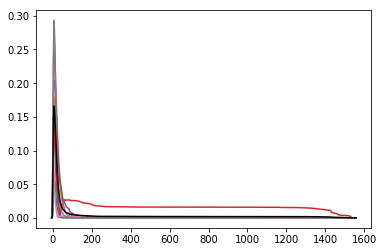

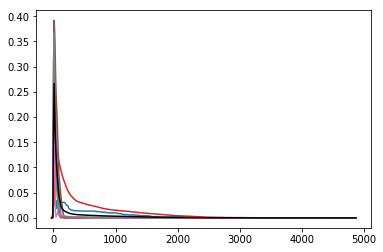

In [174]:
plt.figure(1)
plt.clf()
# plt.imshow(acc_list[0])
plt.plot(bin_edge_list[0],acc_list[0].T);
plt.plot(bin_edge_list[0],np.mean(acc_list[0],axis=0),'k-')

plt.figure(2)
plt.clf()
plt.plot(bin_edge_list[-1],acc_list[-1].T);
plt.plot(bin_edge_list[-1],np.mean(acc_list[-1],axis=0),'k-')

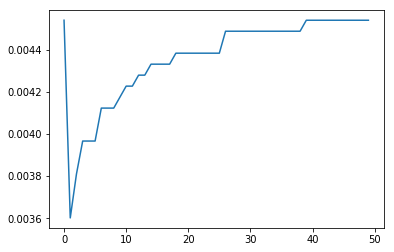

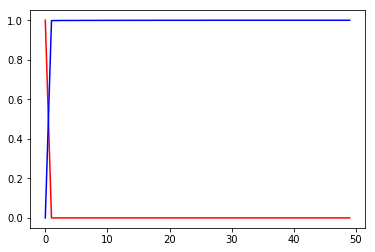

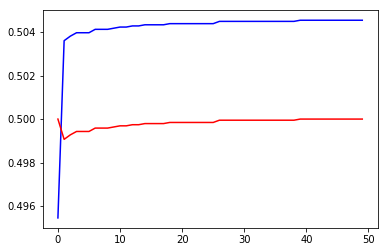

In [145]:
plt.figure(1)
plt.clf()
plt.plot(acc_list[-1])

plt.figure(2)
plt.clf()
plt.plot(sens,'r-')
plt.plot(spec,'b-');

plt.figure(3)
plt.clf()
plt.plot(acc,'b-')
plt.plot((sens+spec)/2,'r-')

In [123]:
## LOAD KMEANS DATA
# list of subs
#subs=[253]
#subs=[1077, 1096, 1125, 115, 253, 264, 273, 442, 565, 590, 620, 862, 922, 958, 970]
subs=[1077, 1096, 115, 253, 442, 565, 590, 620, 922, 958, 970]


# Get file list & figure out max an min feature values
in_fnames=list()
sub_list=list()
# find all subsamp files
in_dir='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/KDOWNSAMP/'
f_ct=0
for f in os.listdir(in_dir):
    if f.startswith('kdownsampled_'):
        in_fnames.append(f)
        tmp=f.split('_')[1]
        sub_list.append(int(tmp.split('.')[0]))
        mat=np.load(os.path.join(in_dir,f))
        if f_ct==0:
            min_ftrs=np.min(mat['ftrs_dsamp'],axis=0)
            max_ftrs=np.max(mat['ftrs_dsamp'],axis=0)
        else:
            min_ftrs=np.minimum(min_ftrs,np.min(mat['ftrs_dsamp'],axis=0))
            max_ftrs=np.maximum(max_ftrs,np.max(mat['ftrs_dsamp'],axis=0))
        f_ct+=1
        
n_band=6
n_edm=5
n_file=len(in_fnames)
print('%d files total' % n_file)
trim_mn=np.zeros(n_file)
trim_sd=np.zeros(n_file)
n_wind=np.zeros(n_file)
bin_edge_list=list()
n_bin_list=list()
n_targ_bin=500
ictal_p_list=list()
nonictal_p_list=list()
band_labels=['Delta','Theta','Alpha','Beta','Gamma','HGamma']
label_list=list()
bin_cntr_list=list()
for a in range(30):
    bin_cntr_list.append([])
    
for edm_ct in range(n_edm):
    for b_ct in range(n_band):
        bin_edge_list.append(np.linspace(min_ftrs[b_ct+edm_ct*n_band],max_ftrs[b_ct+edm_ct*n_band],n_targ_bin))
        n_bin_list.append(len(bin_edge_list[-1])-1)
        ictal_p_list.append(np.zeros(n_bin_list[-1]))
        nonictal_p_list.append(np.zeros(n_bin_list[-1]))
        label_list.append(band_labels[b_ct]+'-EDM'+str(edm_ct))
        
for edm_ct in range(n_edm):
#for edm_ct in range(1):
    pdf_y=np.zeros((n_band,n_bin,n_file,2)) # last dim is nonictal/ictal
    pdf_x=np.zeros((n_band,n_bin,n_file,2))
    for f_ct, f in enumerate(in_fnames):
        mat=np.load(os.path.join(in_dir,f))
        n_wind[f_ct]=mat['ftrs_dsamp'].shape[0]

        raw_ftrs=mat['ftrs_dsamp'].T
        #temp_mns, temp_sds = dg.trimmed_normalize(raw_ftrs, 0.25, zero_nans=False, verbose=False)
        temp_mns, temp_sds = dg.median_normalize(raw_ftrs,zero_nans=False, verbose=False)
        
        # Loop over features
        for b_ct in range(n_band):
            for ictal in range(2):
                # Compute hist and spline
                s=-2+raw_ftrs[b_ct+edm_ct*n_band,mat['szr_class_dsamp']==ictal]/3

                # Normalize
                #s=-2+(s-np.median(s))/(3*iqr(s))
                #p, x = np.histogram(s, bins=n_bin) 
                p, x = np.histogram(s, bins=bin_edge_list[b_ct+edm_ct*n_band]) # bin it into n = N/10 bins
                x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
                bin_cntr_list[b_ct+edm_ct*n_band]=x
                if ictal==0:
                    nonictal_p_list[b_ct+edm_ct*n_band]+=p/(n_file*np.sum(p))
                else:
                    ictal_p_list[b_ct+edm_ct*n_band]+=p/(n_file*np.sum(p))
            

8 files total


In [116]:
print(max_ftrs)
print(min_ftrs)

[  1558.6872954    1859.28390102   2996.31036779   3111.63940001
   5653.52373137  13780.3568669    1633.69058661   2175.6469635
   3100.91862484   3392.90428021   4805.62995426  14596.30378532
   1792.5470949    1965.51609997   2844.57936623   3360.12235525
   5023.39658928  13842.83764005   1982.49065586   1437.83210674
   2234.98338739   3506.15141895   3391.43266687  11091.28194129
   2107.60999804   1164.35823357   1746.46240378   2629.57967047
   2932.46871403   4868.00967262]
[ -6.72011925  -7.86727125 -10.22282945 -17.37343612 -16.05389857
 -16.31933761  -7.61453867  -8.77828467 -12.08514128 -20.85713864
 -18.0357954  -19.01017424  -9.37227067 -11.16931889 -16.9401321
 -27.29067276 -21.93916264 -21.19878634 -11.84349704 -13.15944182
 -22.94605127 -37.27222862 -30.58219457 -24.23659096 -13.63004401
 -14.75768097 -27.73466497 -50.83719742 -37.74987958 -28.42341386]


File saved to trim_explore_nrm_edmA0.jpg
File saved to trim_explore_nrm_edmA1.jpg
File saved to trim_explore_nrm_edmA2.jpg
File saved to trim_explore_nrm_edmA3.jpg
File saved to trim_explore_nrm_edmA4.jpg


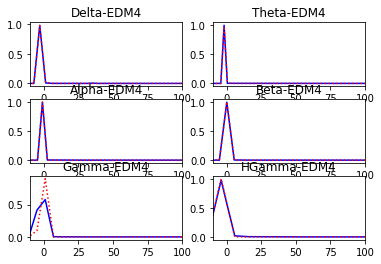

In [124]:
ct=0
for edm_ct in range(n_edm):
    plt.figure(1)
    plt.clf()
    for b_ct in range(n_band):
        plt.subplot(3,2,b_ct+1)
        plt.plot(bin_cntr_list[ct],nonictal_p_list[ct],'b-')
        plt.plot(bin_cntr_list[ct],ictal_p_list[ct],'r:')
        plt.xlim([-10, 100])
#         plt.xscale('log')
        plt.title(label_list[ct])
        ct+=1
#         if b_ct<4:
#             plt.xticks([])
    #out_fname='explore_nrm_edm'+str(edm_ct)+'.jpg'
    out_fname='trim_explore_nrm_edmA'+str(edm_ct)+'.jpg'
    plt.savefig(out_fname)
    print('File saved to %s' % out_fname)

In [97]:
len(bin_edge_list)

30

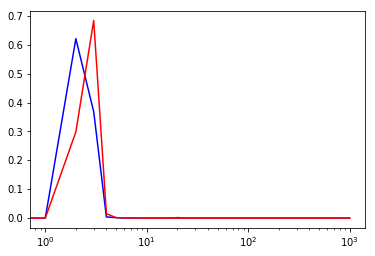

In [96]:
plt.figure(10)
plt.clf()
plt.plot(nonictal_p_list[0],'b-')
plt.plot(ictal_p_list[0],'r-')
# plt.xlim([-10, 10])
plt.xscale('log')

In [73]:
np.linspace?

In [74]:
rng=max_ftrs[b_ct+edm_ct*n_band]-min_ftrs[b_ct+edm_ct*n_band]
bro=np.linspace(min_ftrs[b_ct+edm_ct*n_band],max_ftrs[b_ct+edm_ct*n_band],1000)
bro.shape

(1000,)

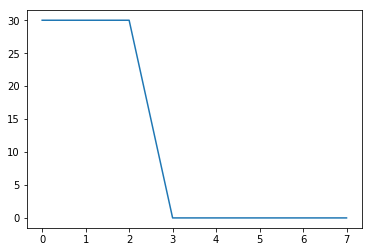

In [23]:
plt.figure(10)
plt.clf()
plt.plot(n_wind)

In [18]:
print(sub_list)
print(in_fnames)

[1077, 1096, 253, 565, 590, 620, 958, 970]
['kdownsampled_1077.npz', 'kdownsampled_1096.npz', 'kdownsampled_253.npz', 'kdownsampled_565.npz', 'kdownsampled_590.npz', 'kdownsampled_620.npz', 'kdownsampled_958.npz', 'kdownsampled_970.npz']


152 files total
File saved to trim_explore_nrm_edm0.jpg


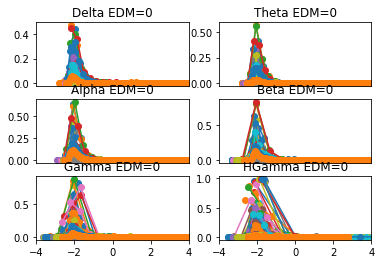

In [3]:
## LOAD SUBSAMPLED DATA
# list of subs
#subs=[1096, 1125]
subs=[1077, 1096, 1125, 115, 253, 264, 273, 442, 565, 590, 620, 862, 922, 958, 970]

in_fnames=list()
sub_list=list()
# find all subsamp files
in_dir='/Users/davidgroppe/Desktop/TRANS'
for f in os.listdir(in_dir):
    if f.endswith('subsamp.mat'):
        in_fnames.append(f)
        sub_list.append(int(f.split('_')[0]))

n_file=len(in_fnames)
print('%d files total' % n_file)
trim_mn=np.zeros(n_file)
trim_sd=np.zeros(n_file)
n_wind=np.zeros(n_file)
#for edm_ct in range(5):
for edm_ct in range(1):
    n_bin=500
    n_band=6
    pdf_y=np.zeros((n_band,n_bin,n_file))
    pdf_x=np.zeros((n_band,n_bin,n_file))
    for f_ct, f in enumerate(in_fnames):
        in_dir='/Users/davidgroppe/Desktop/TRANS'
        mat=sio.loadmat(os.path.join(in_dir,f))
        n_wind[f_ct]=mat['subsamp_se_ftrs'].shape[1]

        raw_ftrs=mat['subsamp_se_ftrs']
        #temp_mns, temp_sds = dg.trimmed_normalize(raw_ftrs, 0.25, zero_nans=False, verbose=False)
        temp_mns, temp_sds = dg.median_normalize(raw_ftrs,zero_nans=False, verbose=False)
        
        # Loop over features
        for b_ct in range(n_band):
            # Compute hist and spline
            #s=mat['subsamp_se_ftrs'][b_ct+edm_ct*n_band,:]
            s=-2+raw_ftrs[b_ct+edm_ct*n_band,:]/3

            # Normalize
            #s=-2+(s-np.median(s))/(3*iqr(s))

            p, x = np.histogram(s, bins=n_bin) # bin it into n = N/10 bins
            x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
            #spline = UnivariateSpline(x, p, s=n_bin)
            pdf_y[b_ct,:,f_ct]=p/np.sum(p)
            pdf_x[b_ct,:,f_ct]=x

    
    band_labels=['Delta','Theta','Alpha','Beta','Gamma','HGamma']
    plt.figure(1)
    plt.clf()
    b_ct=0
    for b_ct in range(n_band):
        plt.subplot(3,2,b_ct+1)
        plt.title(band_labels[b_ct]+' EDM='+str(edm_ct))
        for f_ct in range(n_file):
            plt.plot(pdf_x[b_ct,:,f_ct],pdf_y[b_ct,:,f_ct],'-o')
            plt.xlim([-4, 4])
        if b_ct<4:
            plt.xticks([])
            
    #out_fname='explore_nrm_edm'+str(edm_ct)+'.jpg'
    out_fname='trim_explore_nrm_edm'+str(edm_ct)+'.jpg'
    plt.savefig(out_fname)
    print('File saved to %s' % out_fname)

In [ ]:
plt.xticks

In [ ]:
band_labels=['Delta','Theta','Alpha','Beta','Gamma','HGamma']
plt.figure(1)
b_ct=0
for b_ct in range(n_band):
    plt.subplot(3,2,b_ct+1)
    plt.title(band_labels[b_ct]+' EDM='+str(edm_ct))
    for f_ct in range(n_file):
        plt.plot(pdf_x[b_ct,:,f_ct],pdf_y[b_ct,:,f_ct],'-o')
        plt.xlim([-4, 4])
#plt.xscale('log')

In [ ]:
plt.figure(1)
plt.plot(x,spline(x))
plt.plot(x,p,'r')

In [ ]:
mat.keys()

In [ ]:
mat['ftr_labels'][:7]

In [ ]:
n=100
s=mat['subsamp_se_ftrs'][0,:]
p, x = np.histogram(s, bins=n) # bin it into n = N/10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)

plt.figure(2)
plt.subplot(2,1,1)
plt.plot(x, f(x))

plt.subplot(2,1,2)
plt.hist(s,n);

In [ ]:
# Plot # of time windows per electrode
plt.figure(1)
plt.clf()
plt.plot(n_wind,'o-')
plt.xlabel('Electrode')
plt.ylabel('# of Samples')

print('Min # of time samples %d' % np.min(n_wind))